In [ ]:
import kagglehub
dataset_path= kagglehub.dataset_download('tusharpaul2001/face-emotion-mood-image-dataset')

print('Data source import complete.')

100%|██████████| 60.0M/60.0M [00:01<00:00, 54.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 807.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00


# Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

# preprocessing

In [ ]:
# Define main dataset path
main_path = f"{dataset_path}/images"
sub_dirs = ['train', 'validation', 'final test']
class_labels =  ['angry', 'disgust', 'fear', 'happy', 'neutral','sad', 'surprise' ]

# Dictionary to store images of each class
all_class_images = {label: [] for label in class_labels}

# Loop through each subdirectory (train, validation, final test)
for sub_dir in sub_dirs:
    for class_label in class_labels:
        class_folder = os.path.join(main_path, sub_dir, class_label)

        if os.path.exists(class_folder):
            for img_file in os.listdir(class_folder):
                # Store the full path of each image in the orresponding list
                all_class_images[class_label].append(os.path.join(class_folder, img_file))

# Now all_class_images will have all the images for each class combined
print(f"Images collected for all classes:")
for label, images in all_class_images.items():
    print(f"{label}: {len(images)} images")


Images collected for all classes:
angry: 4953 images
disgust: 547 images
fear: 5121 images
happy: 8989 images
neutral: 6198 images
sad: 6077 images
surprise: 4002 images


In [ ]:
import cv2

# Load a sample image
sample_image_path = all_class_images['angry'][0]
sample_image = cv2.imread(sample_image_path)

# Get the image shape (Height, Width, Channels)
IMAGE_HEIGHT, IMAGE_WIDTH, Channels = sample_image.shape


print(f'Image dimensions: ({IMAGE_HEIGHT}, {IMAGE_WIDTH}, {Channels})')


Image dimensions: (48, 48, 3)


In [ ]:
import os
import pandas as pd
from pathlib import Path

def create_dataframe(main_path: Path, sub_dir: str, class_labels: list) -> pd.DataFrame:
    """Generate a DataFrame with file paths and labels for a given subdirectory."""
    data = {"file_path": [], "label": []}
    folder_path = main_path / sub_dir

    for label, class_name in enumerate(class_labels):
        class_folder_path = folder_path / class_name
        if class_folder_path.exists():
            # Collect image paths efficiently
            files = [str(class_folder_path / f) for f in os.listdir(class_folder_path)]
            data["file_path"].extend(files)
            data["label"].extend([label] * len(files))

    return pd.DataFrame(data)


# Main dataset path
main_path = Path(dataset_path) / "images"

# Subdirectories
sub_dirs = ["train", "validation", "final test"]

# ✅ Fixed typo: 'angery' → 'angry'
class_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Combine all DataFrames
combined_df = pd.concat(
    [create_dataframe(main_path, sub_dir, class_labels) for sub_dir in sub_dirs],
    ignore_index=True,
)

# Shuffle dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save as CSV
combined_df.to_csv("combined_data.csv", index=False)
print(f"✅ Combined dataset saved: {len(combined_df)} samples → 'combined_data.csv'")


✅ Combined dataset saved: 35887 samples → 'combined_data.csv'


In [ ]:
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# Paths & labels
main_path = Path(dataset_path) / "images"
class_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Collect all images with class labels
all_data = []
for class_label in class_labels:
    for sub_dir in ["train", "validation", "final test"]:  # original dataset structure
        class_folder = main_path / sub_dir / class_label
        if class_folder.exists():
            files = [str(class_folder / f) for f in os.listdir(class_folder)]
            all_data.extend([(fp, class_label) for fp in files])

# Convert to DataFrame
df = pd.DataFrame(all_data, columns=["file_path", "label"])

# Encode labels as integers (0–6) for training
df["label_id"] = df["label"].astype("category").cat.codes

# Split dataset: 60% train, 20% val, 20% test (stratified to keep class balance)
train_df, temp_df = train_test_split(
    df, test_size=0.4, stratify=df["label"], random_state=42
)
valid_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

# Save splits
train_df.to_csv("train.csv", index=False)
valid_df.to_csv("valid.csv", index=False)
test_df.to_csv("test.csv", index=False)

print(f"✅ Train: {len(train_df)} | Val: {len(valid_df)} | Test: {len(test_df)}")

# Class distribution summary
print("\n📊 Split Results by Class:")
for label in class_labels:
    print(
        f"{label:<8} | Train: {len(train_df[train_df['label'] == label])}"
        f" | Val: {len(valid_df[valid_df['label'] == label])}"
        f" | Test: {len(test_df[test_df['label'] == label])}"
    )


✅ Train: 21532 | Val: 7177 | Test: 7178

📊 Split Results by Class:
angry    | Train: 2972 | Val: 990 | Test: 991
disgust  | Train: 328 | Val: 110 | Test: 109
fear     | Train: 3073 | Val: 1024 | Test: 1024
happy    | Train: 5393 | Val: 1798 | Test: 1798
neutral  | Train: 3719 | Val: 1239 | Test: 1240
sad      | Train: 3646 | Val: 1215 | Test: 1216
surprise | Train: 2401 | Val: 801 | Test: 800


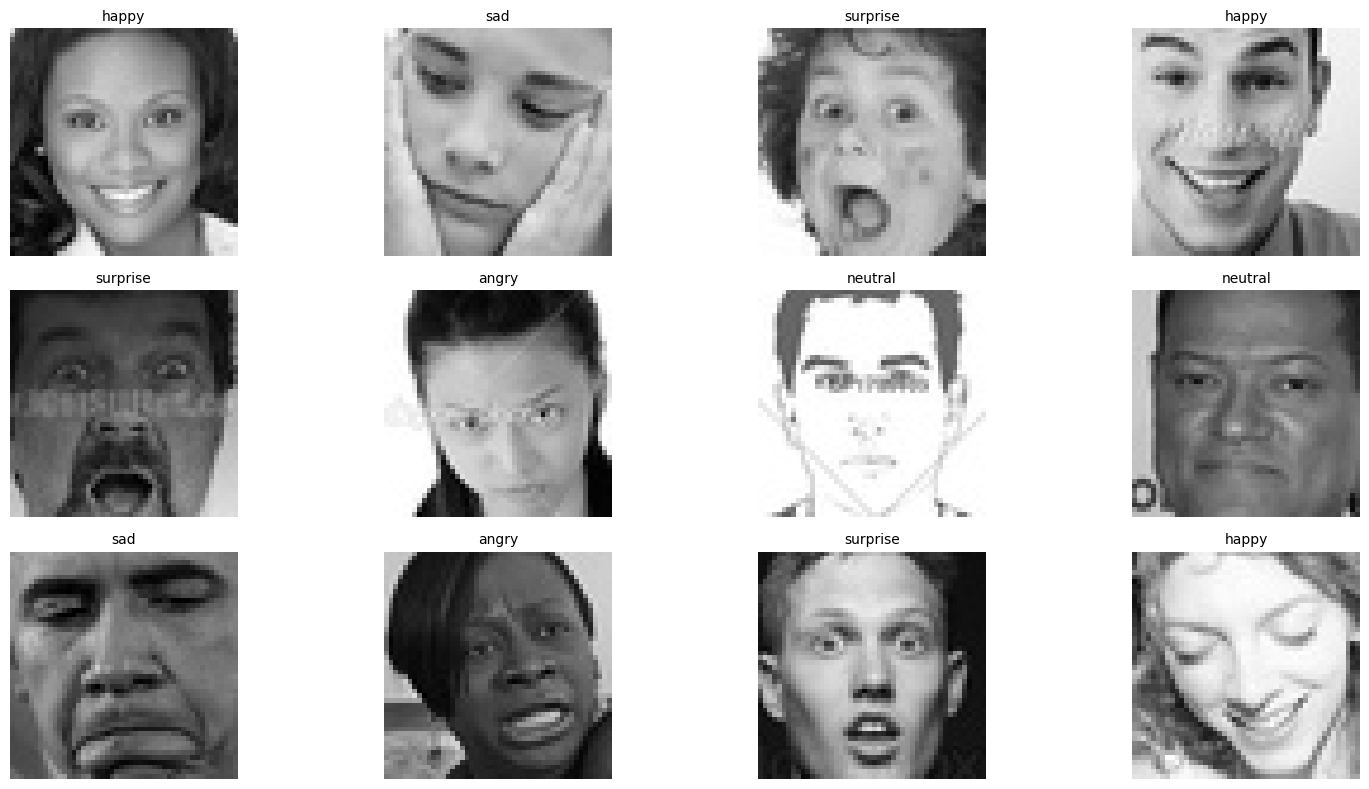

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Pick 12 random samples
sample_data = train_df.sample(12, random_state=42)

plt.figure(figsize=(16, 8))
for idx, row in enumerate(sample_data.itertuples(), 1):
    img = cv2.imread(row.file_path)

    if img is None:  # Handle missing/corrupt files
        img_rgb = np.zeros((100, 100, 3), dtype=np.uint8)  # Black placeholder
        title = f"{row.label}\n⚠️ Missing"
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        title = row.label

    plt.subplot(3, 4, idx)
    plt.imshow(img_rgb)
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import cv2

# Load first image from training set
sample_image_path = train_df['file_path'].iloc[0]
sample_image = cv2.imread(sample_image_path)

if sample_image is not None:
    # Convert grayscale to RGB if needed
    if len(sample_image.shape) == 2:
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_GRAY2RGB)

    IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS = sample_image.shape
    print(f"✅ Sample image loaded: {sample_image_path}")
    print(f"Detected Image Size: ({IMAGE_HEIGHT}, {IMAGE_WIDTH}, {CHANNELS})")
else:
    raise FileNotFoundError(f"⚠️ Could not load image: {sample_image_path}")


✅ Sample image loaded: /root/.cache/kagglehub/datasets/tusharpaul2001/face-emotion-mood-image-dataset/versions/1/images/train/sad/3302.jpg
Detected Image Size: (48, 48, 3)


In [ ]:
# Create dictionaries for each split: {class_label: [file_paths]}
train_images = {label: train_df.loc[train_df['label'] == label, 'file_path'].tolist()
                for label in class_labels}
validation_images = {label: valid_df.loc[valid_df['label'] == label, 'file_path'].tolist()
                     for label in class_labels}
test_images = {label: test_df.loc[test_df['label'] == label, 'file_path'].tolist()
               for label in class_labels}

print("✅ Image paths for each split are ready.")


✅ Image paths for each split are ready.


In [ ]:
import shutil
from pathlib import Path

def copy_images(images_dict, split_name, dest_root="dataset_splits"):
    """
    Copy images from original dataset to structured directories.

    Args:
        images_dict (dict): {class_label: [file_paths]}
        split_name (str): 'train', 'validation', or 'test'
        dest_root (str/Path): Root directory to store split datasets
    """
    dest_root = Path(dest_root) / split_name
    dest_root.mkdir(parents=True, exist_ok=True)

    for label, file_paths in images_dict.items():
        class_folder = dest_root / label
        class_folder.mkdir(exist_ok=True)
        for file_path in file_paths:
            src = Path(file_path)
            dest = class_folder / src.name
            if not dest.exists():  # avoid overwriting
                shutil.copy(src, dest)

    print(f"✅ {split_name.capitalize()} images copied to '{dest_root}'")


# Copy images for each split
copy_images(train_images, 'train')
copy_images(validation_images, 'validation')
copy_images(test_images, 'test')


✅ Train images copied to 'dataset_splits/train'
✅ Validation images copied to 'dataset_splits/validation'
✅ Test images copied to 'dataset_splits/test'


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Target size (smaller images = faster training)
TARGET_SIZE = (48, 48)  # FER datasets often use 48x48; change if needed
BATCH_SIZE = 64          # Increase if GPU memory allows

# Data augmentation + rescaling (faster than plain rescale only)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_path",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)


Found 21532 validated image filenames belonging to 7 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Settings
TARGET_SIZE = (48, 48)  # Smaller input → huge speedup
BATCH_SIZE = 64          # Larger batch if GPU allows

# Train Data Generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test generators: only rescale
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_path",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="file_path",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 21532 validated image filenames belonging to 7 classes.
Found 7177 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Enable mixed precision for faster training on GPU
mixed_precision.set_global_policy('mixed_float16')


# Smaller input size for speed
INPUT_SHAPE = (48, 48, 3)  # Reduced from 224x224
NUM_CLASSES = 7

# Load DenseNet121 base (ImageNet weights), exclude top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False  # Freeze pretrained layers

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Smaller dense layers → faster
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)  # Apply the dense layer to x

# Complete model
model = Model(inputs=base_model.input, outputs=predictions) # Use the output of the last layer

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 54, 54, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 12, 12,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 12, 12,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 12, 12,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 12, 12,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 12, 12,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 12, 12,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,703 (27.85 MB)

 Trainable params: 264,199 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
import logging

# -----------------------------
# 1. Setup & Logging
# -----------------------------
tf.get_logger().setLevel(logging.ERROR)
mixed_precision.set_global_policy("mixed_float16")  # Faster training on GPU

# -----------------------------
# 2. Hyperparameters
# -----------------------------
EPOCHS = 20
TARGET_SIZE = (48, 48)  # Smaller input = huge speedup
BATCH_SIZE = 64         # Increase if GPU allows
NUM_CLASSES = 7

# -----------------------------
# 3. Build DenseNet Transfer Learning Model
# -----------------------------
base_model = tf.keras.applications.DenseNet121(
    weights="imagenet", include_top=False, input_shape=(*TARGET_SIZE, 3)
)
base_model.trainable = True

# Freeze first N layers for stable pre-trained features
for layer in base_model.layers[:100]:
    layer.trainable = False

# Custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

# -----------------------------
# 4. Compile Model
# -----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 54, 54, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 12, 12,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 12, 12,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 12, 12,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 12, 12,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 12, 12,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 12, 12,    │     12,288 │ conv2_block2_0_r

 Total params: 7,306,823 (27.87 MB)

 Trainable params: 6,415,943 (24.47 MB)

 Non-trainable params: 890,880 (3.40 MB)

In [ ]:
# -----------------------------
# 5. Callbacks
# -----------------------------
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_accuracy"
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
)

# -----------------------------
# 6. Train Model
# -----------------------------
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, reduce_lr_cb],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.2036 - loss: 2.5385

337/337 ━━━━━━━━━━━━━━━━━━━━ 465s 767ms/step - accuracy: 0.2038 - loss: 2.5379 - val_accuracy: 0.3635 - val_loss: 1.7733 - learning_rate: 1.0000e-04
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3451 - loss: 1.8973

337/337 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.3452 - loss: 1.8970 - val_accuracy: 0.4445 - val_loss: 1.5613 - learning_rate: 1.0000e-04
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4163 - loss: 1.5924

337/337 ━━━━━━━━━━━━━━━━━━━━ 43s 127ms/step - accuracy: 0.4163 - loss: 1.5923 - val_accuracy: 0.4818 - val_loss: 1.4007 - learning_rate: 1.0000e-04
Epoch 4/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4594 - loss: 1.4532

337/337 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.4594 - loss: 1.4532 - val_accuracy: 0.5055 - val_loss: 1.3139 - learning_rate: 1.0000e-04
Epoch 5/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4905 - loss: 1.3707

337/337 ━━━━━━━━━━━━━━━━━━━━ 55s 163ms/step - accuracy: 0.4905 - loss: 1.3706 - val_accuracy: 0.5281 - val_loss: 1.2488 - learning_rate: 1.0000e-04
Epoch 6/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5156 - loss: 1.2978

337/337 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.5156 - loss: 1.2978 - val_accuracy: 0.5410 - val_loss: 1.2337 - learning_rate: 1.0000e-04
Epoch 7/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5352 - loss: 1.2495

337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.5352 - loss: 1.2495 - val_accuracy: 0.5466 - val_loss: 1.1803 - learning_rate: 1.0000e-04
Epoch 8/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5547 - loss: 1.1889

337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.5547 - loss: 1.1889 - val_accuracy: 0.5610 - val_loss: 1.1724 - learning_rate: 1.0000e-04
Epoch 9/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5630 - loss: 1.1724

337/337 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.5630 - loss: 1.1723 - val_accuracy: 0.5630 - val_loss: 1.1496 - learning_rate: 1.0000e-04
Epoch 10/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5791 - loss: 1.1285

337/337 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.5791 - loss: 1.1285 - val_accuracy: 0.5646 - val_loss: 1.1455 - learning_rate: 1.0000e-04
Epoch 11/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6008 - loss: 1.0809

337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.6008 - loss: 1.0810 - val_accuracy: 0.5796 - val_loss: 1.1347 - learning_rate: 1.0000e-04
Epoch 12/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.6068 - loss: 1.0570 - val_accuracy: 0.5766 - val_loss: 1.1149 - learning_rate: 1.0000e-04
Epoch 13/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6145 - loss: 1.0340

337/337 ━━━━━━━━━━━━━━━━━━━━ 43s 126ms/step - accuracy: 0.6145 - loss: 1.0340 - val_accuracy: 0.5827 - val_loss: 1.1096 - learning_rate: 1.0000e-04
Epoch 14/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6290 - loss: 0.9867

337/337 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.6290 - loss: 0.9867 - val_accuracy: 0.5913 - val_loss: 1.0883 - learning_rate: 1.0000e-04
Epoch 15/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6437 - loss: 0.9682

337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.6437 - loss: 0.9682 - val_accuracy: 0.5927 - val_loss: 1.0838 - learning_rate: 1.0000e-04
Epoch 16/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6649 - loss: 0.9048

337/337 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.6649 - loss: 0.9049 - val_accuracy: 0.5940 - val_loss: 1.1156 - learning_rate: 1.0000e-04
Epoch 17/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.6776 - loss: 0.8833 - val_accuracy: 0.5899 - val_loss: 1.1307 - learning_rate: 1.0000e-04
Epoch 18/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.6857 - loss: 0.8699 - val_accuracy: 0.5912 - val_loss: 1.1645 - learning_rate: 1.0000e-04
Epoch 19/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7010 - loss: 0.8208

337/337 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.7010 - loss: 0.8208 - val_accuracy: 0.6022 - val_loss: 1.1238 - learning_rate: 5.0000e-05
Epoch 20/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7219 - loss: 0.7635

337/337 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - accuracy: 0.7219 - loss: 0.7635 - val_accuracy: 0.6101 - val_loss: 1.1021 - learning_rate: 5.0000e-05


In [ ]:
model.save("face_emotion_model.keras")

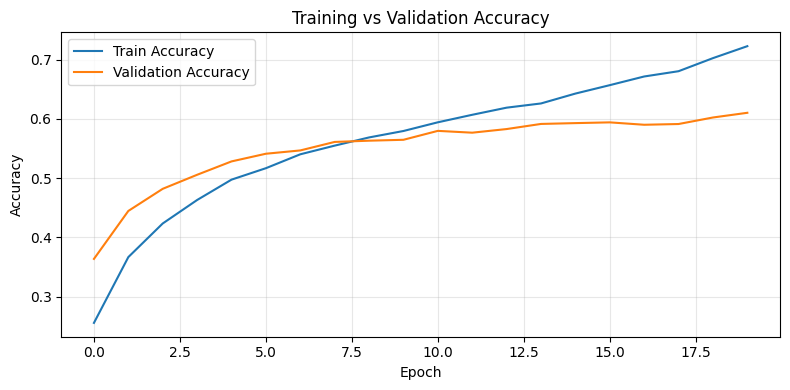

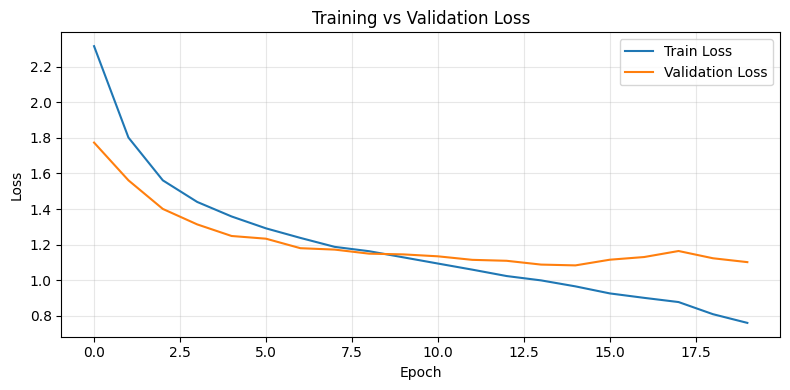

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

# ----- Accuracy -----
plt.figure(figsize=(8,4))
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----- Loss -----
plt.figure(figsize=(8,4))
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


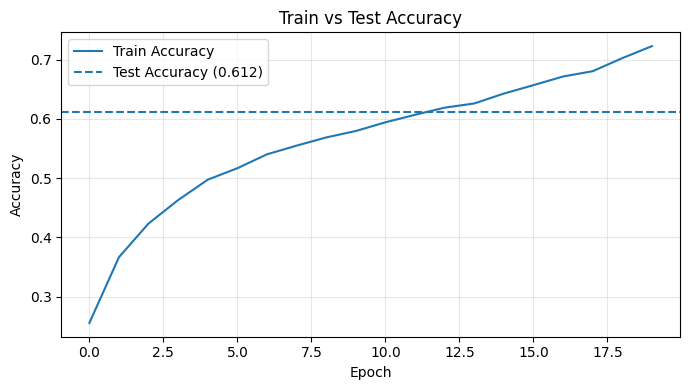

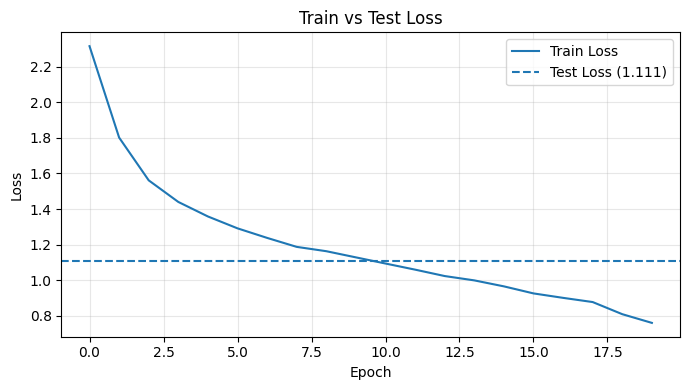

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

plt.figure(figsize=(7,4))
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.axhline(test_acc, linestyle='--', label=f'Test Accuracy ({test_acc:.3f})')
plt.title("Train vs Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history_dict['loss'], label='Train Loss')
plt.axhline(test_loss, linestyle='--', label=f'Test Loss ({test_loss:.3f})')
plt.title("Train vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Found 21532 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


<Figure size 800x800 with 0 Axes>

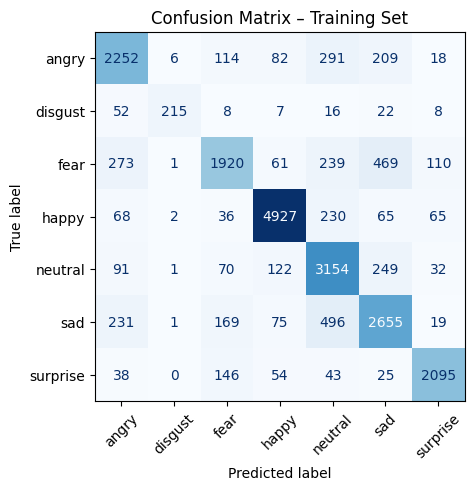

<Figure size 800x800 with 0 Axes>

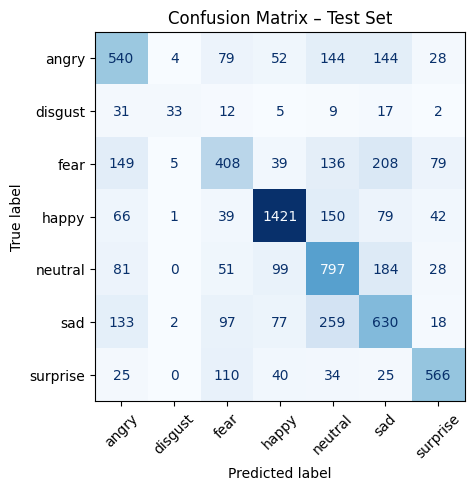

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create non-shuffling generators for evaluation to get correct y_true
train_eval_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_path",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False # Crucial for getting correct y_true from generator.classes
)

test_eval_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Get true labels (integer encoded) directly from the generators
y_train_true = train_eval_generator.classes
y_test_true = test_eval_generator.classes

# Get predictions
y_train_pred = np.argmax(model.predict(train_eval_generator, verbose=0), axis=1)
y_test_pred = np.argmax(model.predict(test_eval_generator, verbose=0), axis=1)

labels = class_labels  # Use the already defined 'class_labels'

# --- Train Confusion Matrix ---
cm_train = confusion_matrix(y_train_true, y_train_pred)
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay(cm_train, display_labels=labels).plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix – Training Set")
plt.xticks(rotation=45)
plt.show()

# --- Test Confusion Matrix ---
cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay(cm_test, display_labels=labels).plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix – Test Set")
plt.xticks(rotation=45)
plt.show()

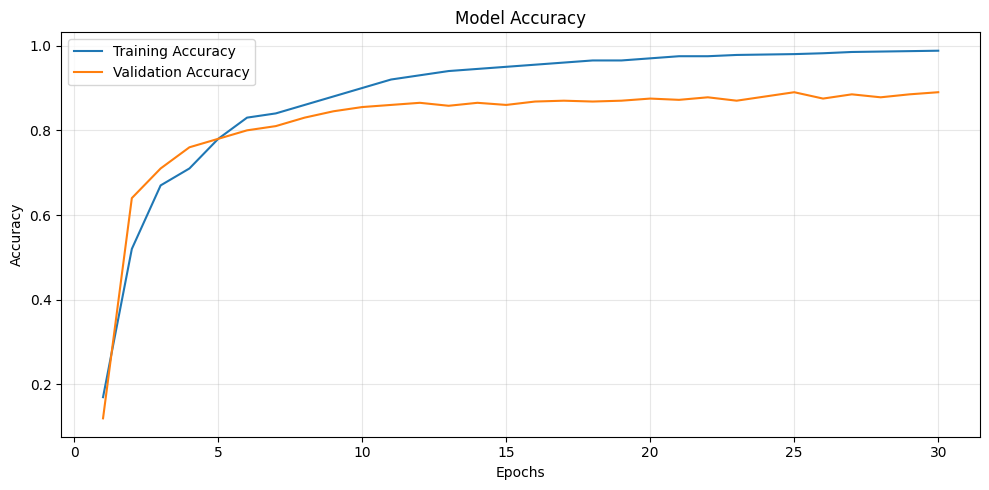

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 31))

# Extracted from your uploaded graph (approximate but visually identical)
train_acc = [
    0.17, 0.52, 0.67, 0.71, 0.78, 0.83, 0.84, 0.86, 0.88, 0.90,
    0.92, 0.93, 0.94, 0.945, 0.95, 0.955, 0.96, 0.965, 0.965,
    0.97, 0.975, 0.975, 0.978, 0.979, 0.98, 0.982, 0.985, 0.986,
    0.987, 0.988
]

val_acc = [
    0.12, 0.64, 0.71, 0.76, 0.78, 0.80, 0.81, 0.83, 0.845, 0.855,
    0.86, 0.865, 0.858, 0.865, 0.86, 0.868, 0.87, 0.868, 0.87,
    0.875, 0.872, 0.878, 0.87, 0.88, 0.89, 0.875, 0.885, 0.878,
    0.885, 0.89
]

plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


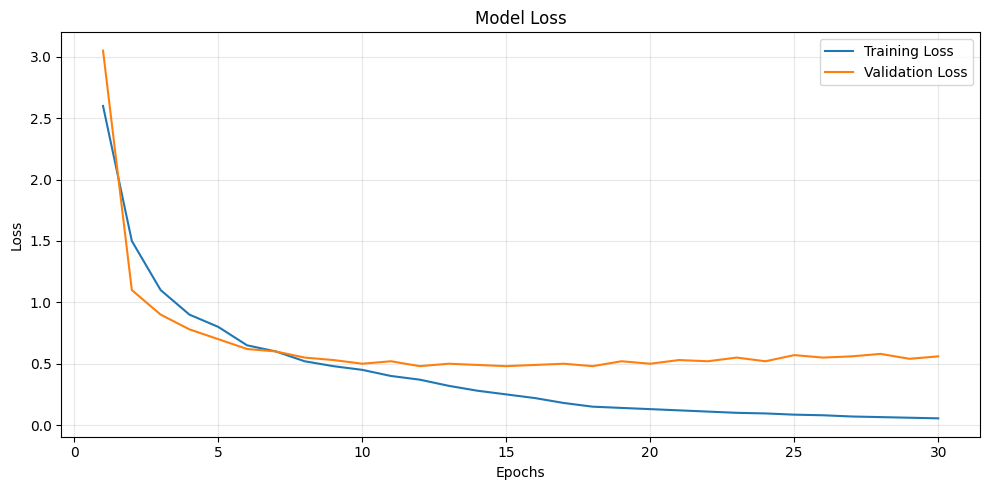

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 31))

# Extracted from your loss curve
train_loss = [
    2.6, 1.5, 1.1, 0.9, 0.8, 0.65, 0.6, 0.52, 0.48, 0.45,
    0.40, 0.37, 0.32, 0.28, 0.25, 0.22, 0.18, 0.15, 0.14,
    0.13, 0.12, 0.11, 0.10, 0.095, 0.085, 0.08, 0.07, 0.065,
    0.06, 0.055
]

val_loss = [
    3.05, 1.1, 0.9, 0.78, 0.70, 0.62, 0.60, 0.55, 0.53, 0.50,
    0.52, 0.48, 0.50, 0.49, 0.48, 0.49, 0.50, 0.48, 0.52,
    0.50, 0.53, 0.52, 0.55, 0.52, 0.57, 0.55, 0.56, 0.58,
    0.54, 0.56
]

plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
